In [5]:
import pandas as pd
import torch
import numpy as np
torch.set_printoptions(precision=2, linewidth=200, sci_mode=False)
np.set_printoptions(precision=2, linewidth=140)
from rdkit.Chem.Draw import IPythonConsole


from src.data import Zinc250_DataLoader

In [6]:
train_loader = Zinc250_DataLoader(batch_size=1, shuffle=False)

next(iter(train_loader))

DataBatch(x=[24, 54], edge_index=[2, 52], edge_attr=[52, 12], smiles=[1], batch=[24], ptr=[2])

In [7]:
zinc_smiles = train_loader.dataset.smiles

In [8]:
zinc_smiles

['CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1',
 'C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1',
 'N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1',
 'CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c2CCCCC3)C1',
 'N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#N)C12CCCCC2',
 'CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br',
 'COc1ccc(C(=O)N(C)[C@@H](C)C/C(N)=N/O)cc1O',
 'O=C(Nc1nc[nH]n1)c1cccnc1Nc1cccc(F)c1',
 'Cc1c(/C=N/c2cc(Br)ccn2)c(O)n2c(nc3ccccc32)c1C#N',
 'C[C@@H]1CN(C(=O)c2cc(Br)cn2C)CC[C@H]1[NH3+]',
 'CCOc1ccc(OCC)c([C@H]2C(C#N)=C(N)N(c3ccccc3C(F)(F)F)C3=C2C(=O)CCC3)c1',
 'Cc1ccc2nc(S[C@H](C)C(=O)NC3CCC(C)CC3)n(C)c(=O)c2c1',
 'O=C(N1CCc2c(F)ccc(F)c2C1)C1(O)Cc2ccccc2C1',
 'Cc1ccccc1C(=O)N1CCC2(CC1)C[C@H](c1ccccc1)C(=O)N2C',
 'CCCc1cc(NC(=O)CN2C(=O)NC3(CCC(C)CC3)C2=O)n(C)n1',
 'CC(C)Cc1nc(SCC(=O)NC[C@@H]2CCCO2)c2c(=O)n(C)c(=O)n(C)c2n1',
 'Cc1ccc(CNC(=O)c2ccccc2NC(=O)[C@@H]2CC(=O)N(c3ccc(C)cc3)C2)cc1',
 'CCCCC(=O)NC(=S)Nc1ccccc1C(=O)N1CCOCC1',
 'Cc1c(NC(=O)CSc2nc3sc4c(c3c(=O)[nH]2)CCCC4)c

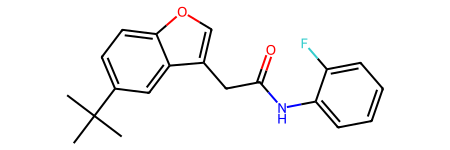

In [9]:
# Graph MAE utils to go from and to mols
from rdkit import Chem
import torch 
import numpy as np
from torch_geometric.data import Data

allowable_features = {
    'possible_atomic_num_list' : list(range(1, 119)),
    'possible_formal_charge_list' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'possible_chirality_list' : [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ],
    'possible_hybridization_list' : [
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED
    ],
    'possible_numH_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'possible_implicit_valence_list' : [0, 1, 2, 3, 4, 5, 6],
    'possible_degree_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'possible_bonds' : [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ],
    'possible_bond_dirs' : [ # only for double bond stereo information
        Chem.rdchem.BondDir.NONE,
        Chem.rdchem.BondDir.ENDUPRIGHT,
        Chem.rdchem.BondDir.ENDDOWNRIGHT
    ]
}

def mol_to_graph_data_obj_simple(mol):
    """
    Converts rdkit mol object to graph Data object required by the pytorch
    geometric package. NB: Uses simplified atom and bond features, and represent
    as indices
    :param mol: rdkit mol object
    :return: graph data object with the attributes: x, edge_index, edge_attr
    """
    # atoms
    num_atom_features = 2   # atom type,  chirality tag
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_feature = [allowable_features['possible_atomic_num_list'].index(
            atom.GetAtomicNum())] + [allowable_features[
            'possible_chirality_list'].index(atom.GetChiralTag())]
        atom_features_list.append(atom_feature)
    x = torch.tensor(np.array(atom_features_list), dtype=torch.long)

    # bonds
    num_bond_features = 2   # bond type, bond direction
    if len(mol.GetBonds()) > 0: # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_feature = [allowable_features['possible_bonds'].index(
                bond.GetBondType())] + [allowable_features[
                                            'possible_bond_dirs'].index(
                bond.GetBondDir())]
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = torch.tensor(np.array(edges_list).T, dtype=torch.long)

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = torch.tensor(np.array(edge_features_list),
                                 dtype=torch.long)
    else:   # mol has no bonds
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, num_bond_features), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return data

def graph_data_obj_to_mol_simple(data_x, data_edge_index, data_edge_attr):
    """
    Convert pytorch geometric data obj to rdkit mol object. NB: Uses simplified
    atom and bond features, and represent as indices.
    :param: data_x:
    :param: data_edge_index:
    :param: data_edge_attr
    :return:
    """
    mol = Chem.RWMol()

    # atoms
    atom_features = data_x.cpu().numpy()
    num_atoms = atom_features.shape[0]
    for i in range(num_atoms):
        atomic_num_idx, chirality_tag_idx = atom_features[i]
        atomic_num = allowable_features['possible_atomic_num_list'][atomic_num_idx]
        chirality_tag = allowable_features['possible_chirality_list'][chirality_tag_idx]
        atom = Chem.Atom(atomic_num)
        atom.SetChiralTag(chirality_tag)
        mol.AddAtom(atom)

    # bonds
    edge_index = data_edge_index.cpu().numpy()
    edge_attr = data_edge_attr.cpu().numpy()
    num_bonds = edge_index.shape[1]
    for j in range(0, num_bonds, 2):
        begin_idx = int(edge_index[0, j])
        end_idx = int(edge_index[1, j])
        bond_type_idx, bond_dir_idx = edge_attr[j]
        bond_type = allowable_features['possible_bonds'][bond_type_idx]
        bond_dir = allowable_features['possible_bond_dirs'][bond_dir_idx]
        mol.AddBond(begin_idx, end_idx, bond_type)
        # set bond direction
        new_bond = mol.GetBondBetweenAtoms(begin_idx, end_idx)
        new_bond.SetBondDir(bond_dir)

    # Chem.SanitizeMol(mol) # fails for COC1=CC2=C(NC(=N2)[S@@](=O)CC2=NC=C(
    # C)C(OC)=C2C)C=C1, when aromatic bond is possible
    # when we do not have aromatic bonds
    # Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_KEKULIZE)

    return mol

Chem.MolFromSmiles(zinc_smiles[0])
data = mol_to_graph_data_obj_simple(Chem.MolFromSmiles(zinc_smiles[0]))
data, data.x.T, data.edge_attr.T
graph_data_obj_to_mol_simple(data.x, data.edge_index, data.edge_attr)

In [10]:
from typing import List, Tuple
from functools import partial

from rdkit import Chem
import torch
from torch_geometric.data import Data as TorchGeometricData

from src.featurizer.dgllife import (
    atom_type_one_hot,
    atom_chiral_tag_one_hot,
    bond_type_one_hot,
    bond_direction_one_hot,
)

class SimpleGraph2dFeaturizer:
    """
    Atom features: Atom type, Chirality type
    Edge features: Bond type, Bond direction
    """
    LIST_BOND_FEATURIZERS =  [lambda bond: [bond_type_one_hot(bond).index(True)], lambda bond: [bond_direction_one_hot(bond).index(True)]]
    
    ALLOW_ATOM_TYPES = list(range(1, 119))

    CHIRAL_TYPES = [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ]

    BOND_TYPES = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]

    BOND_DIR = [
        Chem.rdchem.BondDir.NONE,
        Chem.rdchem.BondDir.ENDUPRIGHT,
        Chem.rdchem.BondDir.ENDDOWNRIGHT
    ]

    def _get_vertex_features(self, mol: Chem.Mol) -> List[List[float]]:
        return [self._featurize_atom(atom) for atom in mol.GetAtoms()]
    
    def _featurize_atom(self, atom: Chem.Atom) -> List[float]:
        return np.concatenate([featurizer(atom) for featurizer in self._list_atom_featurizers()])
    
    def _list_atom_featurizers(self):
     return [
            # lambda atom: [atom_type_one_hot(atom, allowable_set=self.allowed_atom_types, encode_unknown=False).index(True)],
            lambda atom: [atom.GetAtomicNum() - 1],
            lambda atom: [atom_chiral_tag_one_hot(atom).index(True)]
    ]

    def _get_edge_features(self, mol: Chem.Mol) -> Tuple[List[List[int]], List[List[float]]]:
        edge_indices, edge_attributes = [], []
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            bond_features = self._featurize_bond(bond)

            edge_indices.extend([[i, j], [j, i]])
            edge_attributes.extend([bond_features] * 2)

        return edge_indices, edge_attributes
    
    def _featurize_bond(self, bond: Chem.Bond) -> List[float]:
        return np.concatenate([featurizer(bond) for featurizer in self.LIST_BOND_FEATURIZERS])

    def __call__(self, smiles: str) -> TorchGeometricData:
        mol = Chem.MolFromSmiles(smiles)
        
        atom_features = self._get_vertex_features(mol)
        atom_features = torch.LongTensor(atom_features).view(-1, len(atom_features[0]))

        edge_indices, edge_attributes = self._get_edge_features(mol)
        edge_indices = torch.tensor(edge_indices, dtype=torch.long).t()
        edge_attributes = torch.LongTensor(edge_attributes)

        return TorchGeometricData(x=atom_features, edge_index=edge_indices, edge_attr=edge_attributes, smiles=smiles)
    
    def decode(self, data: TorchGeometricData) -> Chem.Mol:
        mol = Chem.RWMol()

        # atoms
        atom_features = data.x.cpu().numpy()
        num_atoms = atom_features.shape[0]
        for i in range(num_atoms):
            atomic_num_idx, chirality_tag_idx = atom_features[i]
            atomic_num = self.ALLOW_ATOM_TYPES[int(atomic_num_idx)]
            chirality_tag = self.CHIRAL_TYPES[int(chirality_tag_idx)]
            atom = Chem.Atom(atomic_num)
            atom.SetChiralTag(chirality_tag)
            mol.AddAtom(atom)

        # bonds
        edge_index = data.edge_index.cpu().numpy()
        edge_attr = data.edge_attr.cpu().numpy()
        num_bonds = edge_index.shape[1]
        for j in range(0, num_bonds, 2):
            begin_idx = int(edge_index[0, j])
            end_idx = int(edge_index[1, j])
            bond_type_idx, bond_dir_idx = edge_attr[j]
            bond_type = self.BOND_TYPES[int(bond_type_idx)]
            bond_dir = self.BOND_DIR[int(bond_dir_idx)]
            mol.AddBond(begin_idx, end_idx, bond_type)
            # set bond direction
            new_bond = mol.GetBondBetweenAtoms(begin_idx, end_idx)
            new_bond.SetBondDir(bond_dir)

        return mol

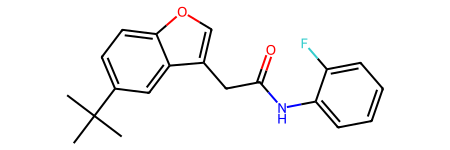

In [11]:
Chem.MolFromSmiles(zinc_smiles[0])

In [12]:
data = SimpleGraph2dFeaturizer()(zinc_smiles[0])
data, data.x.T, data.edge_attr.T

/tmp/ipykernel_642202/3140251481.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/utils/tensor_new.cpp:230.)
  atom_features = torch.LongTensor(atom_features).view(-1, len(atom_features[0]))


(Data(x=[24, 2], edge_index=[2, 52], edge_attr=[52, 2], smiles='CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1'),
 tensor([[5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 7, 6, 5, 5, 5, 5, 5, 5, 8, 5, 5],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

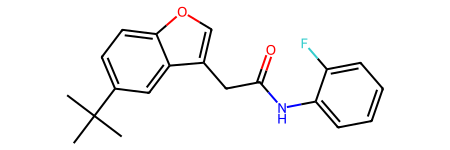

In [13]:
SimpleGraph2dFeaturizer().decode(data)

In [14]:
import random
from copy import deepcopy
from typing import Optional
import math
import torch.nn.functional as F

class RandomAtomMask:
    TOKEN_VALUE = 119

    def __init__(self, prob: float = 1.0):
        """
        @param p: the probability of the transform being applied; default value is 1.0. If
                  a list is passed in, the value will be randomly and sampled between the two
                  end points.
        @param input_field: the name of the generated input containing the smile information
            should be a PyG_Data object
        """
        if isinstance(prob, list):
            assert 0 <= prob[0] <= 1.0
            assert 0 <= prob[1] <= 1.0
            assert prob[0] < prob[1]
        else:
            assert 0 <= prob <= 1.0, "p must be a value in the range [0, 1]"
        self.prob = prob


    def __call__(self, data: Data, seed=None) -> Data:
        """
        @param mol_graph: PyG Data to be augmented
        @param metadata: if set to be a list, metadata about the function execution
            including its name, the source & dest width, height, etc. will be appended to
            the inputted list. If set to None, no metadata will be appended or returned
        @returns: Augmented PyG Data
        """
        if isinstance(self.prob, list):
            self.p = random.uniform(self.prob[0], self.prob[1])
        else:
            self.p = self.prob

        assert isinstance(self.p, (float, int))
        assert isinstance(data, Data), "mol_graph passed in must be a PyG Data"
        output = self.apply_transform(data, seed)
        return output

    def apply_transform(self, data: Data, seed: Optional[None] = None) -> Data:
        """
        Transform that randomly mask atoms given a certain ratio
        @param mol_graph: PyG Data to be augmented
        @param seed:
        @returns: Augmented PyG Data
        """
        if seed is not None:
            random.seed(seed)
        num_atoms = data.x.size(0)
        num_mask_nodes = max([1, math.floor(self.p * num_atoms)])
        mask_nodes = sorted(random.sample(list(range(num_atoms)), num_mask_nodes))

        mask_data = deepcopy(data)
        # mask_data.x[mask_nodes, :] = torch.ones(len(mask_data.x[mask_nodes, :])) * self.TOKEN_VALUE
        
        # Graph-MAE apply only to the atom indice
        # Note: Not sure what they set the chirality at 0 for the mask
        mask_data.x[mask_nodes, :] = torch.tensor([self.TOKEN_VALUE, 0])
        mask_data.masked_atom_indices = torch.zeros(num_atoms, dtype=torch.bool)
        mask_data.masked_atom_indices[torch.tensor(mask_nodes)] = 1
        mask_data.node_attr_label = F.one_hot(data.x[mask_nodes, 0], num_classes=119).float()

        return mask_data

In [15]:
# GraphMAE implementation of MaskAtom
class MaskAtom:
    def __init__(self, num_atom_type, num_edge_type, mask_rate, mask_edge=True):
        """
        Randomly masks an atom, and optionally masks edges connecting to it.
        The mask atom type index is num_possible_atom_type
        The mask edge type index in num_possible_edge_type
        :param num_atom_type:
        :param num_edge_type:
        :param mask_rate: % of atoms to be masked
        :param mask_edge: If True, also mask the edges that connect to the
        masked atoms
        """
        self.num_atom_type = num_atom_type
        self.num_edge_type = num_edge_type
        self.mask_rate = mask_rate
        self.mask_edge = mask_edge
        
        self.num_chirality_tag = 3
        self.num_bond_direction = 3 


    def __call__(self, data, masked_atom_indices=None):
        """

        :param data: pytorch geometric data object. Assume that the edge
        ordering is the default pytorch geometric ordering, where the two
        directions of a single edge occur in pairs.
        Eg. data.edge_index = tensor([[0, 1, 1, 2, 2, 3],
                                     [1, 0, 2, 1, 3, 2]])
        :param masked_atom_indices: If None, then randomly samples num_atoms
        * mask rate number of atom indices
        Otherwise a list of atom idx that sets the atoms to be masked (for
        debugging only)
        :return: None, Creates new attributes in original data object:
        data.mask_node_idx
        data.mask_node_label
        data.mask_edge_idx
        data.mask_edge_label
        """

        if masked_atom_indices == None:
            # sample x distinct atoms to be masked, based on mask rate. But
            # will sample at least 1 atom
            num_atoms = data.x.size()[0]
            sample_size = int(num_atoms * self.mask_rate + 1)
            masked_atom_indices = random.sample(range(num_atoms), sample_size)

        # create mask node label by copying atom feature of mask atom
        mask_node_labels_list = []
        for atom_idx in masked_atom_indices:
            mask_node_labels_list.append(data.x[atom_idx].view(1, -1))
        data.mask_node_label = torch.cat(mask_node_labels_list, dim=0)
        data.masked_atom_indices = torch.tensor(masked_atom_indices)

        # ----------- graphMAE -----------
        atom_type = F.one_hot(data.mask_node_label[:, 0], num_classes=self.num_atom_type).float()
        atom_chirality = F.one_hot(data.mask_node_label[:, 1], num_classes=self.num_chirality_tag).float()
        # data.node_attr_label = torch.cat((atom_type,atom_chirality), dim=1)
        data.node_attr_label = atom_type

        # modify the original node feature of the masked node
        for atom_idx in masked_atom_indices:
            data.x[atom_idx] = torch.tensor([self.num_atom_type, 0])

        if self.mask_edge:
            # create mask edge labels by copying edge features of edges that are bonded to
            # mask atoms
            connected_edge_indices = []
            for bond_idx, (u, v) in enumerate(data.edge_index.cpu().numpy().T):
                for atom_idx in masked_atom_indices:
                    if atom_idx in set((u, v)) and \
                        bond_idx not in connected_edge_indices:
                        connected_edge_indices.append(bond_idx)

            if len(connected_edge_indices) > 0:
                # create mask edge labels by copying bond features of the bonds connected to
                # the mask atoms
                mask_edge_labels_list = []
                for bond_idx in connected_edge_indices[::2]: # because the
                    # edge ordering is such that two directions of a single
                    # edge occur in pairs, so to get the unique undirected
                    # edge indices, we take every 2nd edge index from list
                    mask_edge_labels_list.append(
                        data.edge_attr[bond_idx].view(1, -1))

                data.mask_edge_label = torch.cat(mask_edge_labels_list, dim=0)
                # modify the original bond features of the bonds connected to the mask atoms
                for bond_idx in connected_edge_indices:
                    data.edge_attr[bond_idx] = torch.tensor(
                        [self.num_edge_type, 0])

                data.connected_edge_indices = torch.tensor(
                    connected_edge_indices[::2])
            else:
                data.mask_edge_label = torch.empty((0, 2)).to(torch.int64)
                data.connected_edge_indices = torch.tensor(
                    connected_edge_indices).to(torch.int64)

            edge_type = F.one_hot(data.mask_edge_label[:, 0], num_classes=self.num_edge_type).float()
            bond_direction = F.one_hot(data.mask_edge_label[:, 1], num_classes=self.num_bond_direction).float()
            data.edge_attr_label = torch.cat((edge_type, bond_direction), dim=1)
            # data.edge_attr_label = edge_type

        return data

    def __repr__(self):
        return '{}(num_atom_type={}, num_edge_type={}, mask_rate={}, mask_edge={})'.format(
            self.__class__.__name__, self.num_atom_type, self.num_edge_type,
            self.mask_rate, self.mask_edge)

data = mol_to_graph_data_obj_simple(Chem.MolFromSmiles(zinc_smiles[5]))
mask_data = MaskAtom(119, 4, 0.5, mask_edge=False)(data)
mask_data, mask_data.x.T, mask_data.edge_attr.T, sorted(mask_data.masked_atom_indices.tolist())

(Data(x=[17, 2], edge_index=[2, 34], edge_attr=[34, 2], mask_node_label=[9, 2], masked_atom_indices=[9], node_attr_label=[9, 119]),
 tensor([[  5, 119, 119, 119, 119,   5,   5,   5, 119,   5, 119,   5,   5, 119, 119, 119,  34],
         [  0,   0,   0,   0,   0,   2,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 [1, 2, 3, 4, 8, 10, 13, 14, 15])

In [16]:
data = mol_to_graph_data_obj_simple(Chem.MolFromSmiles(zinc_smiles[5]))
rmask_data = RandomAtomMask(0.5)(data)
rmask_data, rmask_data.x.T, rmask_data.edge_attr.T, sorted(rmask_data.masked_atom_indices.tolist())

(Data(x=[17, 2], edge_index=[2, 34], edge_attr=[34, 2], masked_atom_indices=[17], node_attr_label=[8, 119]),
 tensor([[119, 119, 119,   5, 119, 119,   5,   5,   5,   5,   7, 119, 119,  15, 119,   5,  34],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True])

In [17]:
rmask_data.masked_atom_indices, rmask_data.node_attr_label

(tensor([ True,  True,  True, False,  True,  True, False, False, False, False, False,  True,  True, False,  True, False, False]),
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [18]:
data
data, data.x.T, data.edge_attr.T

(Data(x=[17, 2], edge_index=[2, 34], edge_attr=[34, 2]),
 tensor([[ 5,  5,  6,  5,  5,  5,  5,  5,  5,  5,  7,  5,  5, 15,  5,  5, 34],
         [ 0,  0,  0,  0,  0,  2,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

## Dataset definition

In [19]:
from functools import partial

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch_geometric.loader.dataloader import Collator
# from torch_geometric.loader import DataLoader

from GraphMAE.chem.loader import mol_to_graph_data_obj_simple


class Zinc250(Dataset):
    BASE_PATH = "/nasa/shared_homes/vincent/sandbox/GraphMAE/"
    # ZINC_PATH = f"{BASE_PATH}src/datasets/zinc250k.csv"
    ZINC_PATH = f"{BASE_PATH}dataset/zinc_standard_agent/processed/smiles.csv"

    def __init__(self):
        super().__init__()
        # self.smiles = pd.read_csv(self.ZINC_PATH)["smiles"].tolist()
        self.smiles = pd.read_csv(self.ZINC_PATH, header=None)[0].tolist()
        # self.featurizer = mol_to_graph_data_obj_simple#SimpleGraph2dFeaturizer()
        self.featurizer = SimpleGraph2dFeaturizer()
        self.masking_strategy = RandomAtomMask(prob=0.25)
        # self.masking_strategy = MaskAtom(num_atom_type = 119, num_edge_type = 5, mask_rate = 0.25, mask_edge=0)

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        return self.masking_strategy(self.featurizer(self.smiles[idx]), seed=42)


# Is needed with default implementation of GraphMAE using indices, but here we change the implementation
# to use mask and avoid collator issues.
class MaskCollator(Collator):
    """masked_atom_indices needs to be sorted for the batching to work"""

    def __call__(self, batch):
        data = super().__call__(batch)

        mask = data.masked_atom_indices.clone()
        graph_cumsum_sizes = data.ptr[1:]

        # Calculate graph boundaries based on changes in mask values
        boundaries = torch.where(mask[:-1] >= mask[1:])[0] + 1
        boundaries = torch.cat([boundaries, torch.tensor([data.num_nodes])])

        for i in range(len(boundaries) - 1):
            start, end = boundaries[i], boundaries[i + 1]
            mask[start:end] += graph_cumsum_sizes[i]

        data.masked_atom_indices = mask

        return data


In [20]:
# Collator
dataset = Zinc250()
dataset = dataset
dataloader = DataLoader(dataset, batch_size=256, collate_fn=MaskCollator([], []))

## Network

In [21]:
from GraphMAE.chem.model import GINConv
import torch

num_atom_type = 120 #including the extra mask tokens
num_chirality_tag = 3

num_bond_type = 6 #including aromatic and self-loop edge, and extra masked tokens
num_bond_direction = 3 

class GNN(torch.nn.Module):
    """
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        max_pool_layer (int): the layer from which we use max pool rather than add pool for neighbor aggregation
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat

    Output:
        node representations

    """
    def __init__(self, num_layer, emb_dim, drop_ratio = 0):
        super(GNN, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        self.x_embedding1 = torch.nn.Embedding(num_atom_type, emb_dim)
        self.x_embedding2 = torch.nn.Embedding(num_chirality_tag, emb_dim)

        torch.nn.init.xavier_uniform_(self.x_embedding1.weight.data)
        torch.nn.init.xavier_uniform_(self.x_embedding2.weight.data)

        ###List of MLPs
        self.gnns = torch.nn.ModuleList()
        for layer in range(num_layer):
            self.gnns.append(GINConv(emb_dim, emb_dim, aggr = "add"))

        ###List of batchnorms
        self.batch_norms = torch.nn.ModuleList()
        for layer in range(num_layer):
            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

    #def forward(self, x, edge_index, edge_attr):
    def forward(self, x, edge_index, edge_attr):
        x = self.x_embedding1(x[:,0]) + self.x_embedding2(x[:,1])

        h_list = [x]
        for layer in range(self.num_layer):
            h = self.gnns[layer](h_list[layer], edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            #h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            if layer < self.num_layer - 1:
                #remove relu for the last layer
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            else:
                h = F.dropout(h, self.drop_ratio, training = self.training)
            h_list.append(h)

        return h_list[-1]


In [22]:
import networkx as nx 
import matplotlib.pyplot as plt

def show_pyg_graph(data: Data, ax=None):
    """
    Visualizes a PyTorch Geometric Data object as a graph.
    
    Parameters:
        data (Data): A PyTorch Geometric Data object.
        ax (matplotlib.axes.Axes, optional): A matplotlib axis object for plotting.
            If None, a new figure and axis will be created.
    
    Returns:
        matplotlib.axes.Axes: The axis on which the graph is plotted.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Convert PyTorch Geometric Data to NetworkX graph
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    for i, (source, target) in enumerate(data.edge_index.t().tolist()):
        G.add_edge(source, target, feature=data.edge_attr[i].cpu().detach().numpy())

    # Layout for our nodes
    pos = nx.spring_layout(G, seed=42)

    # Drawing nodes and edges
    nx.draw_networkx(G, pos, node_size=700, node_color='skyblue', with_labels=True, ax=ax)

    # Drawing labels for each node based on the features
    labels = {i: f'{np.round(data.x[i].cpu().detach().numpy(), 2)}' for i in range(data.num_nodes)}  # Round for readability
    label_pos = {i: (pos[i][0], pos[i][1] + 0.05) for i in range(data.num_nodes)}
    nx.draw_networkx_labels(G, label_pos, labels, ax=ax, font_size=20)

    # Drawing edge labels based on edge features
    edge_labels = nx.get_edge_attributes(G, 'feature')
    edge_labels_pos = {i: (pos[i][0] + 0.05, pos[i][1] - 0.05) for i in range(data.num_nodes)}
    nx.draw_networkx_edge_labels(G, edge_labels_pos, edge_labels=edge_labels, ax=ax, font_size=20)

    ax.set_title('Graph Visualization with Node and Edge Features from PyTorch Geometric')
    return ax

In [23]:
# Opening up the implementation of the GIN convolution
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops


class SimpleGINConv(MessagePassing):
    """
    Extension of GIN aggregation to incorporate edge information by concatenation.

    Args:
        emb_dim (int): dimensionality of embeddings for nodes and edges.
        embed_input (bool): whether to embed input or not. 
        

    See https://arxiv.org/abs/1810.00826
    """
    def __init__(self, emb_dim, out_dim, aggr = "add", **kwargs):
        kwargs.setdefault('aggr', aggr)
        self.aggr = aggr
        super().__init__(**kwargs)
        #multi-layer perceptron
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 2*emb_dim), 
            torch.nn.ReLU(), 
            torch.nn.Linear(2*emb_dim, out_dim)
        )
    
    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out):
        return self.mlp(aggr_out)
data = SimpleGraph2dFeaturizer()("CCNC")

# Adding self loops and edge_attr for the self loops
edge_index, _ = add_self_loops(data.edge_index, num_nodes = data.x.size(0))
#add features corresponding to self-loop edges.
self_loop_attr = torch.zeros(data.x.size(0), 2)
self_loop_attr[:,0] = 4 #bond type for self-loop edge
self_loop_attr = self_loop_attr.to(data.edge_attr.device).to(data.edge_attr.dtype)
edge_attr = torch.cat((data.edge_attr, self_loop_attr), dim = 0)

data.edge_index = edge_index
data.edge_attr = edge_attr

emb_dim = 2
# Embedding of the atoms features (inseide GNN Model)
num_atom_type = 120 #including the extra mask tokens
num_chirality_tag = 3
atom_type_emb = torch.nn.Embedding(num_atom_type, emb_dim)
chiral_type_emb = torch.nn.Embedding(num_chirality_tag, emb_dim)

# Embedding of the edge features (inside GIN conv)
num_bond_type = 6 #including aromatic and self-loop edge, and extra masked tokens
num_bond_direction = 3 
bond_type_embedding = torch.nn.Embedding(num_bond_type, emb_dim)
bond_direction_embedding = torch.nn.Embedding(num_bond_direction, emb_dim)

# Apply emb
data_emb = data.clone()
data_emb.x = atom_type_emb(data.x[:, 0]) + chiral_type_emb(data.x[:, 1])
data_emb.edge_attr = bond_type_embedding(data.edge_attr[:, 0]) + bond_direction_embedding(data.edge_attr[:, 1])

# Apply conv
data_out = data_emb.clone()
out = SimpleGINConv(emb_dim, 1, aggr="add")(data_emb.x, data_emb.edge_index, data_emb.edge_attr)
data_out.x = out.detach()

In [24]:
encoder = GNN(num_layer=5, emb_dim=500, drop_ratio=0); encoder

GNN(
  (x_embedding1): Embedding(120, 500)
  (x_embedding2): Embedding(3, 500)
  (gnns): ModuleList(
    (0): GINConv()
    (1): GINConv()
    (2): GINConv()
    (3): GINConv()
    (4): GINConv()
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [25]:
data = SimpleGraph2dFeaturizer()(zinc_smiles[0])
data, encoder(data.x, data.edge_index, data.edge_attr).shape, encoder(data.x, data.edge_index, data.edge_attr)

(Data(x=[24, 2], edge_index=[2, 52], edge_attr=[52, 2], smiles='CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1'),
 torch.Size([24, 500]),
 tensor([[ 1.01,  0.56, -0.32,  ...,  0.29, -0.48,  0.56],
         [ 2.21,  0.49,  0.79,  ...,  1.15,  0.59,  0.23],
         [ 1.01,  0.56, -0.32,  ...,  0.29, -0.48,  0.56],
         ...,
         [-1.58,  0.43, -0.21,  ..., -0.03,  1.11, -0.94],
         [ 0.45, -0.29,  0.80,  ..., -1.75, -1.05,  0.05],
         [ 0.11,  0.92,  0.49,  ..., -1.57, -1.42,  0.46]], grad_fn=<NativeBatchNormBackward0>))

In [26]:
class GNNDecoder(torch.nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super().__init__()
        self.conv = GINConv(hidden_dim, out_dim, aggr = "add")
        self.enc_to_dec = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)    
        self.activation = torch.nn.PReLU() 


    def forward(self, x, edge_index, edge_attr, mask_node_indices):
        x = self.activation(x)
        x = self.enc_to_dec(x)
        x[mask_node_indices] = 0
        # x[mask_node_indices] = self.dec_token
        out = self.conv(x, edge_index, edge_attr)
        # out = F.softmax(out, dim=-1) / self.temp
        return out

In [27]:
decoder = GNNDecoder(hidden_dim=500, out_dim=119); decoder

GNNDecoder(
  (conv): GINConv()
  (enc_to_dec): Linear(in_features=500, out_features=500, bias=False)
  (activation): PReLU(num_parameters=1)
)

In [31]:
data = RandomAtomMask(0.5)(SimpleGraph2dFeaturizer()(zinc_smiles[5]))
emb = encoder(data.x, data.edge_index, data.edge_attr)
out = decoder(emb, data.edge_index, data.edge_attr, mask_node_indices=data.masked_atom_indices)
data, out.shape, out

(Data(x=[17, 2], edge_index=[2, 34], edge_attr=[34, 2], smiles='CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br', masked_atom_indices=[17], node_attr_label=[8, 119]),
 torch.Size([17, 119]),
 tensor([[ 0.02,  0.08,  0.01,  ..., -0.00, -0.03,  0.02],
         [-0.23,  0.03, -0.01,  ...,  0.20, -0.14, -0.08],
         [-0.55,  0.06,  0.05,  ...,  0.51, -0.21, -0.09],
         ...,
         [ 0.03,  0.02, -0.06,  ...,  0.07, -0.05,  0.06],
         [ 0.12, -0.00, -0.03,  ...,  0.13, -0.04,  0.14],
         [ 0.06, -0.01, -0.05,  ...,  0.12, -0.02,  0.16]], grad_fn=<AddmmBackward0>))

## SCE Loss

While I understand the use of the loss for a simple example in 2 dimension and for matching embeddings. I am not sure of it's use for atom reconstruction.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def sce_loss(x, y, alpha=1):
    x = F.normalize(x, p=2, dim=-1)
    y = F.normalize(y, p=2, dim=-1)
    loss = (1 - (x * y).sum(dim=-1)).pow_(alpha)
    return loss.mean()

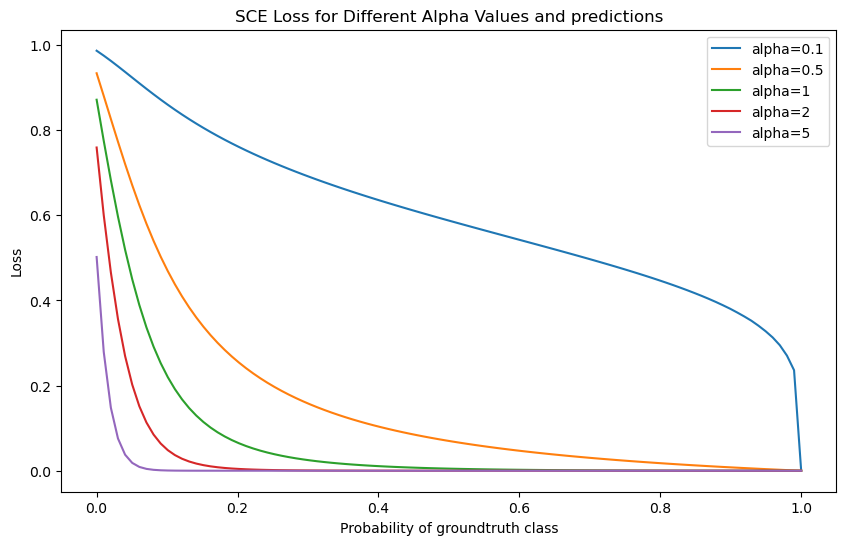

In [33]:
# Current case with 119 binary atom prediction and one positive value

# Generate a single ground truth atom
y = torch.zeros(119, dtype=torch.float32)  # A fixed vector for x
y[0] = 1

# Generate a random prediction x
x = torch.rand(119)
sum_x = x.sum()

# Compute finer predictions of x
pred_gt_range = np.linspace(0, 1, 100)
x_predictions = []
for pred_gt in pred_gt_range:
    pred = x.clone() - x * pred_gt 
    pred[0] = x[0] + (sum_x * pred_gt)
    x_predictions.append(pred) 


# Calculate loss for different values of alpha
alphas = [0.1, 0.5, 1, 2, 5]  # Different alpha values to visualize
losses = {alpha: [] for alpha in alphas}

for alpha in alphas:
    for pred in x_predictions:
        loss = sce_loss(torch.unsqueeze(y, 0), torch.unsqueeze(pred, 0), alpha=alpha).item()
        losses[alpha].append(loss)

# Plotting
plt.figure(figsize=(10, 6))
for alpha, loss_values in losses.items():
    plt.plot(pred_gt_range, loss_values, label=f'alpha={alpha}')

plt.xlabel('Probability of groundtruth class')
plt.ylabel('Loss')
plt.title('SCE Loss for Different Alpha Values and predictions')
plt.legend()
plt.show()


## Training

In [34]:
def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss=None):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    if valid_loss is None:
        y = [train_loss]
        graphs = [[x,train_loss]]
    else:
        y = np.concatenate((train_loss, valid_loss))
        graphs = [[x,train_loss], [x,valid_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, len(train_loss)+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

In [35]:
from GraphMAE.chem.dataloader import DataLoaderMaskingPred
from GraphMAE.chem.loader import MoleculeDataset


dataset_original = MoleculeDataset("dataset/" + "zinc_standard_agent", dataset="zinc_standard_agent")
dataloader_original = DataLoaderMaskingPred(dataset_original, batch_size=2, shuffle=False, mask_rate=0, mask_edge=0)

DataBatch(x=[6727, 2], edge_index=[2, 14594], edge_attr=[14594, 2], smiles=[256], masked_atom_indices=[6727], node_attr_label=[1587, 119], batch=[6727], ptr=[257])


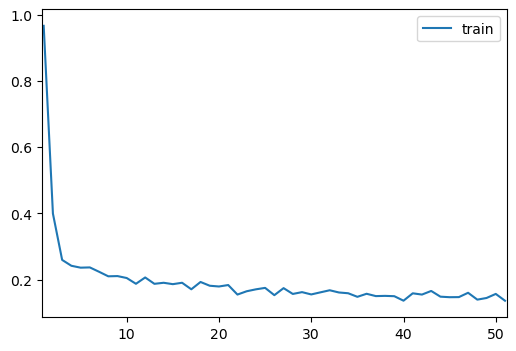

DataBatch(x=[7024, 2], edge_index=[2, 15218], edge_attr=[15218, 2], smiles=[256], masked_atom_indices=[7024], node_attr_label=[1662, 119], batch=[7024], ptr=[257])
DataBatch(x=[7010, 2], edge_index=[2, 15166], edge_attr=[15166, 2], smiles=[256], masked_atom_indices=[7010], node_attr_label=[1661, 119], batch=[7010], ptr=[257])
DataBatch(x=[6842, 2], edge_index=[2, 14826], edge_attr=[14826, 2], smiles=[256], masked_atom_indices=[6842], node_attr_label=[1610, 119], batch=[6842], ptr=[257])
DataBatch(x=[6854, 2], edge_index=[2, 14902], edge_attr=[14902, 2], smiles=[256], masked_atom_indices=[6854], node_attr_label=[1614, 119], batch=[6854], ptr=[257])
DataBatch(x=[6720, 2], edge_index=[2, 14586], edge_attr=[14586, 2], smiles=[256], masked_atom_indices=[6720], node_attr_label=[1587, 119], batch=[6720], ptr=[257])
DataBatch(x=[6835, 2], edge_index=[2, 14764], edge_attr=[14764, 2], smiles=[256], masked_atom_indices=[6835], node_attr_label=[1617, 119], batch=[6835], ptr=[257])
DataBatch(x=[656

KeyboardInterrupt: 

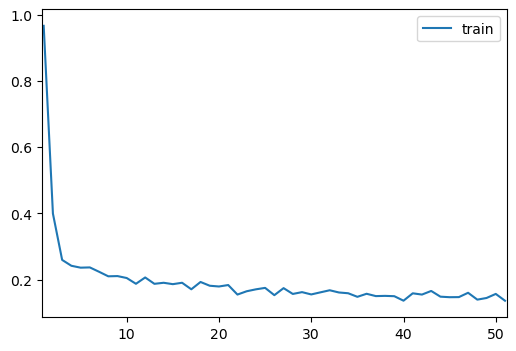

In [37]:
from fastprogress.fastprogress import master_bar, progress_bar
import torch.optim as optim
from torch.utils.data import Subset 
from GraphMAE.chem.dataloader import DataLoaderMasking
from itertools import chain

dataset = Zinc250()
dataloader = DataLoader(dataset, batch_size=256, collate_fn=Collator([], []))

device = "cuda:2"

encoder = GNN(num_layer=5, emb_dim=500, drop_ratio=0).to(device)
decoder = GNNDecoder(hidden_dim=500, out_dim=119).to(device)

# optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001, weight_decay=0)
parameters = chain(encoder.parameters(), decoder.parameters())
optimizer_decoder = optim.Adam(parameters, lr=0.001, weight_decay=0)

criterion = sce_loss

epochs = 100
mbar = master_bar(range(1, epochs+1))
train_loss = []
for epoch in mbar:
    for step, batch in enumerate(progress_bar(dataloader)):
        print(batch)
        batch: Data = batch.to(device)
        node_rep = encoder(batch.x, batch.edge_index, batch.edge_attr)

        ## loss for nodes
        node_attr_label = batch.node_attr_label
        masked_node_indices = batch.masked_atom_indices
        masked_node_indices = torch.where((batch.x  == torch.tensor([119, 0]).to(device)).all(axis=1))[0]
        pred_node = decoder(node_rep, batch.edge_index, batch.edge_attr, masked_node_indices)
        
        loss = criterion(node_attr_label, pred_node[masked_node_indices])

        # acc_node = compute_accuracy(pred_node, batch.mask_node_label[:,0])
        # acc_node_accum += acc_node

        # optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()


        loss.backward()

        # optimizer_encoder.step()
        optimizer_decoder.step()


        
        train_loss.append(float(loss.cpu().item()))
        plot_loss_update(len(train_loss), epochs * len(dataloader), mbar, train_loss)
        # epoch_iter.set_description(f"train_loss: {loss.item():.4f}")
    print("train_loss", np.mean(train_loss[-100:]))

    # loss_accum/step #, acc_node_accum/step, acc_edge_accum/step


BatchMasking(node_attr_label=[1843, 119], id=[256], masked_atom_indices=[1843], mask_node_label=[1843, 2], edge_attr=[14594, 2], x=[6727, 2], edge_index=[2, 14594], batch=[6727])


/nasa/shared_homes/vincent/sandbox/GraphMAE/.env/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


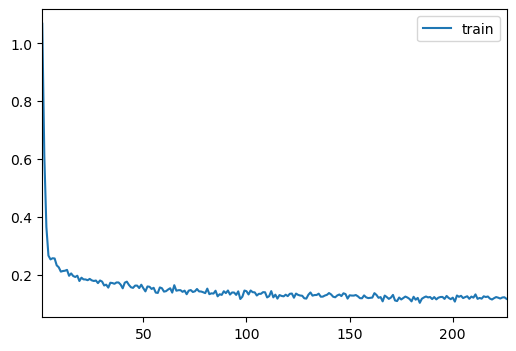

BatchMasking(node_attr_label=[1918, 119], id=[256], masked_atom_indices=[1918], mask_node_label=[1918, 2], edge_attr=[15218, 2], x=[7024, 2], edge_index=[2, 15218], batch=[7024])
BatchMasking(node_attr_label=[1917, 119], id=[256], masked_atom_indices=[1917], mask_node_label=[1917, 2], edge_attr=[15166, 2], x=[7010, 2], edge_index=[2, 15166], batch=[7010])
BatchMasking(node_attr_label=[1866, 119], id=[256], masked_atom_indices=[1866], mask_node_label=[1866, 2], edge_attr=[14826, 2], x=[6842, 2], edge_index=[2, 14826], batch=[6842])
BatchMasking(node_attr_label=[1870, 119], id=[256], masked_atom_indices=[1870], mask_node_label=[1870, 2], edge_attr=[14902, 2], x=[6854, 2], edge_index=[2, 14902], batch=[6854])
BatchMasking(node_attr_label=[1843, 119], id=[256], masked_atom_indices=[1843], mask_node_label=[1843, 2], edge_attr=[14586, 2], x=[6720, 2], edge_index=[2, 14586], batch=[6720])
BatchMasking(node_attr_label=[1873, 119], id=[256], masked_atom_indices=[1873], mask_node_label=[1873, 2]

KeyboardInterrupt: 

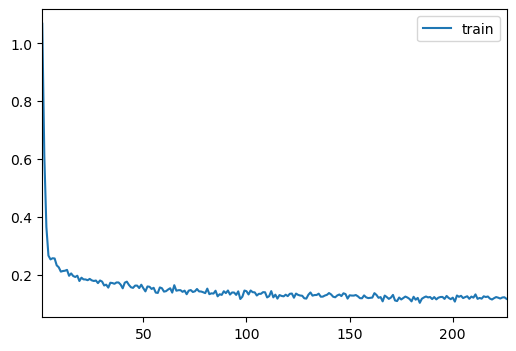

In [145]:
from fastprogress.fastprogress import master_bar, progress_bar
import torch.optim as optim
from torch.utils.data import Subset 

# dataset = Zinc250()
# dataset = dataset
# dataloader = DataLoader(dataset, batch_size=256)
dataset = MoleculeDataset("dataset/" + "zinc_standard_agent", dataset="zinc_standard_agent")
dataloader = DataLoaderMaskingPred(dataset, batch_size=256, shuffle=False, mask_rate=0.25, mask_edge=0)


device = "cuda:2"

encoder = GNN(num_layer=5, emb_dim=500, drop_ratio=0).to(device)
decoder = GNNDecoder(hidden_dim=500, out_dim=119).to(device)

optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001, weight_decay=0)
optimizer_decoder = optim.Adam(decoder.parameters(), lr=0.001, weight_decay=0)

criterion = sce_loss

epochs = 100
mbar = master_bar(range(1, epochs+1))
train_loss = []
for epoch in mbar:
    for step, batch in enumerate(progress_bar(dataloader)):
        print(batch)
        batch: Data = batch.to(device)
        node_rep = encoder(batch.x, batch.edge_index, batch.edge_attr)

        ## loss for nodes
        node_attr_label = batch.node_attr_label
        masked_node_indices = batch.masked_atom_indices
        pred_node = decoder(node_rep, batch.edge_index, batch.edge_attr, masked_node_indices)
        
        loss = criterion(node_attr_label, pred_node[masked_node_indices])

        # acc_node = compute_accuracy(pred_node, batch.mask_node_label[:,0])
        # acc_node_accum += acc_node

        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()


        loss.backward()

        optimizer_encoder.step()
        optimizer_decoder.step()


        
        train_loss.append(float(loss.cpu().item()))
        plot_loss_update(len(train_loss), epochs * len(dataloader), mbar, train_loss)
        # epoch_iter.set_description(f"train_loss: {loss.item():.4f}")
    print("train_loss", np.mean(train_loss[-100:]))

    # loss_accum/step #, acc_node_accum/step, acc_edge_accum/step


In [38]:
class GraphMAE(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, data):
        node_rep = self.encoder(data.x, data.edge_index, data.edge_attr)

        ## loss for nodes
        masked_node_indices = data.masked_atom_indices
        pred_node = self.decoder(node_rep, edge_index, edge_attr, masked_node_indices)
        # loss = criterion(pred_node.double(), batch.mask_node_label[:,0])

        return pred_node

In [39]:
from src.utils.onnx_export import save_model_onnx
    
    
list_names = ["x", "edge_index", "edge_attr", "masked_atom_indices"]
batch = next(iter(dataloader))
batch = batch.to(device)
input_values = tuple([batch.to_dict()[k] for k in list_names])
save_model_onnx(GraphMAE(), batch, ["graph_data"], ["node_predictions"], "./")

RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: DataBatch